In [130]:
#from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [36]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [8]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

[NbConvertApp] Converting notebook utils_edit_mb.ipynb to script
[NbConvertApp] Writing 4903 bytes to utils_edit_mb.py


In [54]:
s_data = pd.read_csv('/Users/m/IDAO2020/train.csv', index_col= 'id')

In [30]:
s_data_test = pd.read_csv('/Users/m/IDAO2020/Track 1/test.csv', index_col= 'id')

In [32]:
s_data['epoch'] = ((pd.to_datetime(s_data['epoch']) - pd.to_datetime(s_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)

In [34]:
s_data['dt'] = s_data['epoch'].diff(1)
s_data['dt'].head()

id
0         NaN
1    0.032442
2    0.032442
3    0.032442
4    0.032442
Name: dt, dtype: float64

In [125]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [140]:
data = get_satellite_data(s_data, 0)
data.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,7182.757625,28395.590633,15553.985280,-1.360095,0.984696,-3.173250
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,3099.591832,29798.085757,6083.094021,-1.536935,-0.033515,-3.544768


In [142]:
remove_time_jumps_fast(data).tail()

Int64Index([267, 800], dtype='int64')


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,16500.142585,-16659.015498,38663.758749,0.348049,2.417738,0.716754,30.852471,0.032442
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,17188.352435,-9636.397802,40000.703601,0.140060,2.579759,0.231032,30.884913,0.032442
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,17269.627379,-2275.948161,39925.025372,-0.084964,2.656988,-0.290960,30.917355,0.032442
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,16696.850918,5166.718053,38337.176299,-0.326478,2.635548,-0.847468,30.949797,0.032442
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946,30.982239,0.032442


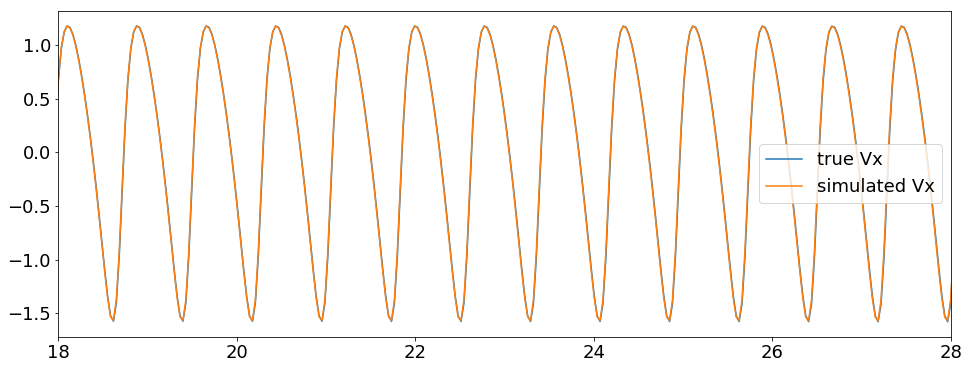

In [135]:
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx')
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx')

plt.xlim([18,28])
plt.legend()

In [146]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

In [147]:
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|██████████| 600/600 [00:07<00:00, 78.08it/s]


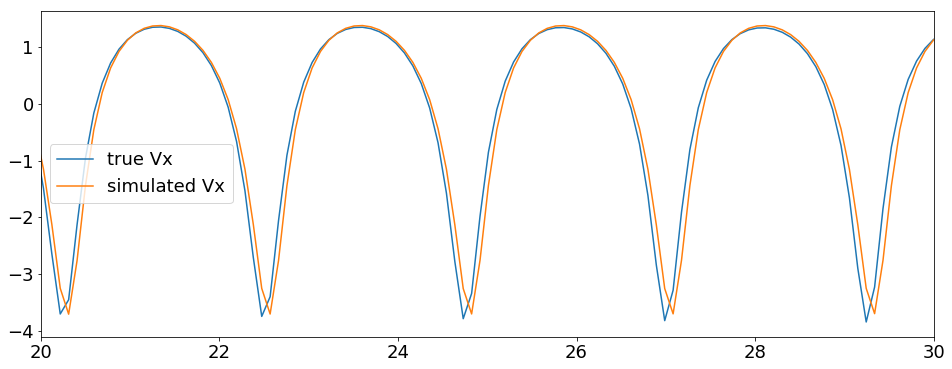

In [167]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 9))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx')
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx')

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend()